# Introduction

## Imports

In [26]:
from data.InstagramAPI.InstagramAPI import InstagramAPI
from data.plots import plot_confusion_matrix
from datetime import datetime
from imutils import paths #pip install opencv-python
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import requests
import shutil
import sys
import tensorflow as tf
import time

### Install Packages

In [ ]:
pip install requests

In [ ]:
pip install imutils

In [ ]:
pip install opencv-python

In [ ]:
#On Anaconda Prompt:
#pip install tensorflow

In [ ]:
pip install keras

## Global Functions

In [2]:
def log_print(data):
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - {data}", flush=True)

def create_path(path):
    if not os.path.exists(path):
        os.mkdir(path)
        log_print(f"Path '{path}' was created.")

def delete_path(path):
    if os.path.exists(path):
        shutil.rmtree(path, ignore_errors=True)
        log_print(f"Path '{path}' was deleted.")

## Configs

In [22]:
TYPE = "guastafriends"

DATE_BEGIN = datetime(2020,6,1,0,0).timestamp()

PATH_BASE                  = os.getcwd()
PATH_BASE_DATA             = os.path.join(PATH_BASE, "data")
PATH_1_CREATING_DATASET    = os.path.join(PATH_BASE_DATA, "1-Creating_Dataset")
PATH_FIRST_DATASET         = os.path.join(PATH_1_CREATING_DATASET, "Dataset")
PATH_FIRST_DATASET_TYPE    = os.path.join(PATH_FIRST_DATASET, TYPE)
PATH_2_PREPARING_DATASET   = os.path.join(PATH_BASE_DATA, "2-Preparing_Dataset")
PATH_CLEAN_DATASET         = os.path.join(PATH_2_PREPARING_DATASET, "Clean_Dataset")
PATH_CLEAN_DATASET_TYPE    = os.path.join(PATH_CLEAN_DATASET, TYPE)
PATH_3_PROCESSING_DATASET  = os.path.join(PATH_BASE_DATA, "3-Processing_Dataset")
PATH_4_CLASSIFYING_DATASET = os.path.join(PATH_BASE_DATA, "4-Classifying_Dataset")

RAIO_FOLLOWERS = 3
RAIO_LIKES = 95

BATCH_LABEL_COUNTER = 7500

BATCH_SIZE = 60
CV = 10

print(f"DATE_BEGIN                : {DATE_BEGIN}")
print(f"PATH_BASE                 : {PATH_BASE}")
print(f"PATH_BASE_DATA            : {PATH_BASE_DATA}")
print(f"PATH_1_CREATING_DATASET   : {PATH_1_CREATING_DATASET}")
print(f"PATH_FIRST_DATASET        : {PATH_FIRST_DATASET}")
print(f"PATH_FIRST_DATASET_TYPE   : {PATH_FIRST_DATASET_TYPE}")
print(f"PATH_2_PREPARING_DATASET  : {PATH_2_PREPARING_DATASET}")
print(f"PATH_CLEAN_DATASET        : {PATH_CLEAN_DATASET}")
print(f"PATH_CLEAN_DATASET_TYPE   : {PATH_CLEAN_DATASET_TYPE}")
print(f"PATH_3_PROCESSING_DATASET : {PATH_3_PROCESSING_DATASET}")
print(f"PATH_4_CLASSIFYING_DATASET: {PATH_4_CLASSIFYING_DATASET}")

DATE_BEGIN                : 1590980400.0
PATH_BASE                 : D:\IC\tcc_insta
PATH_BASE_DATA            : D:\IC\tcc_insta\data
PATH_1_CREATING_DATASET   : D:\IC\tcc_insta\data\1-Creating_Dataset
PATH_FIRST_DATASET        : D:\IC\tcc_insta\data\1-Creating_Dataset\Dataset
PATH_FIRST_DATASET_TYPE   : D:\IC\tcc_insta\data\1-Creating_Dataset\Dataset\guastafriends
PATH_2_PREPARING_DATASET  : D:\IC\tcc_insta\data\2-Preparing_Dataset
PATH_CLEAN_DATASET        : D:\IC\tcc_insta\data\2-Preparing_Dataset\Clean_Dataset
PATH_CLEAN_DATASET_TYPE   : D:\IC\tcc_insta\data\2-Preparing_Dataset\Clean_Dataset\guastafriends
PATH_3_PROCESSING_DATASET : D:\IC\tcc_insta\data\3-Processing_Dataset
PATH_4_CLASSIFYING_DATASET: D:\IC\tcc_insta\data\4-Classifying_Dataset


### Reset Type

In [4]:
delete_path(PATH_FIRST_DATASET_TYPE)
delete_path(PATH_CLEAN_DATASET_TYPE)

### Checking Folders

In [5]:
create_path(PATH_BASE_DATA)
create_path(PATH_1_CREATING_DATASET)
create_path(PATH_FIRST_DATASET)
create_path(PATH_FIRST_DATASET_TYPE)
create_path(PATH_2_PREPARING_DATASET)
create_path(PATH_CLEAN_DATASET)
create_path(PATH_CLEAN_DATASET_TYPE)
create_path(PATH_3_PROCESSING_DATASET)
create_path(PATH_4_CLASSIFYING_DATASET)

2021-06-21 22:59:23 - Path 'D:\IC\tcc_insta\data\1-Creating_Dataset\Dataset\guastafriends' was created.
2021-06-21 22:59:23 - Path 'D:\IC\tcc_insta\data\2-Preparing_Dataset\Clean_Dataset\guastafriends' was created.


# Creating Dataset

## Getting Data

In [6]:
with open(os.path.join(PATH_1_CREATING_DATASET, "logins.json")) as json_file:
     file_logins = json.load(json_file)

def error_log(acc, log_type, e):
    log_print(f"Failed to process {acc} account: {str(e)}")
    log_print(f"Appending to file {TYPE}_users_error.log")
    error_file = open(os.path.join(PATH_1_CREATING_DATASET, f"{TYPE}_users_error.log"), "a")
    error_file.write(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - {log_type} - {acc} - {str(e)}")
    error_file.write("\n")
    error_file.close()
    print("**********************************************\n")
        
def get_login(id_login=0, logins=file_logins["Logins"]):
    api = None
    logged = False
    while not logged:      
        log_print("Trying login in account: " + logins[id_login]["username"])
        api = InstagramAPI(logins[id_login]["username"], logins[id_login]["password"])
        logged = api.login()
        if not logged:
            id_login += 1
            if id_login >= len(logins):
                id_login = 0
            time.sleep(3)
    return (api, id_login)
        
def get_accounts():
    file_accounts = open(os.path.join(PATH_1_CREATING_DATASET, f"{TYPE}_users.txt"), 'r')
    if not os.path.exists(os.path.join(PATH_1_CREATING_DATASET, f"{TYPE}_users.bkp")):
        shutil.copyfile(os.path.join(PATH_1_CREATING_DATASET, f"{TYPE}_users.txt"), os.path.join(PATH_1_CREATING_DATASET, f"{TYPE}_users.bkp"))
    list_accounts = file_accounts.readlines()
    file_accounts.close()
    return list_accounts

def create_folder_acc(acc):
    if not os.path.exists(os.path.join(PATH_FIRST_DATASET_TYPE, acc)):
        log_print(f"Creating folder {acc}")
        if not os.path.exists(PATH_FIRST_DATASET_TYPE):
            os.mkdir(PATH_FIRST_DATASET_TYPE)
        os.mkdir(os.path.join(PATH_FIRST_DATASET_TYPE, acc))
        log_print(f"Folder {acc} created")

def create_file_user_info(user):
    log_print("Creating file user_info")
    user["collected_at"] = datetime.timestamp(datetime.now())
    with open(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "user_info.json"), 'w+', encoding="utf-8") as json_file:
        json.dump(user, json_file, indent=4, ensure_ascii=False)
    log_print("File user_info created")

def get_user_feed(api, id_login, user, next_max_id=None):
    get_user_feed = False
    while not get_user_feed:
        if next_max_id == None:
            api.getUserFeed(user['pk'], minTimestamp=int(DATE_BEGIN))
        else:
            api.getUserFeed(user['pk'], maxid=next_max_id, minTimestamp=int(DATE_BEGIN))
        if api.LastResponse.status_code == 429:
            (api, id_login) = get_login(id_login=id_login)
        else:
            get_user_feed = True
    return (api, id_login)

def create_file_user_posts(api, id_login, user):
    log_print("Creating file user_posts")
    (api, id_login) = get_user_feed(api, id_login, user)
    
    if api.LastResponse.status_code == 400:
        raise Exception(api.LastJson)
        
    posts = api.LastJson

    while (posts["more_available"]):
        time.sleep(round(random.uniform(1,3), 1))
        aux_bool = False
        (api, id_login) = get_user_feed(api, id_login, user, posts["next_max_id"])

        posts["items"].extend(api.LastJson["items"])
        posts["num_results"] += api.LastJson["num_results"]
        posts["more_available"] =  api.LastJson["more_available"]
        if posts["more_available"]:
            posts["next_max_id"] = api.LastJson["next_max_id"]
        else:
            del posts['next_max_id']
        posts["auto_load_more_enabled"] = api.LastJson["auto_load_more_enabled"]
        posts["status"] = api.LastJson["status"]
    posts["collected_at"] = datetime.timestamp(datetime.now())
    with open(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "user_posts.json"), 'w+', encoding="utf-8") as json_file:
        json.dump(posts, json_file, indent=4, ensure_ascii=False)
    log_print("File user_posts created")

In [7]:
(api, id_login) = get_login()

log_print("Type: " + TYPE)
log_print("Starting...\n")

list_accounts = get_accounts()
for acc in list_accounts:
    acc = str(acc).strip()

    try:
        log_print(f"Searching account {acc}")
        time.sleep(round(random.uniform(0.5, 1.5), 1))
        api.searchUsername(acc)
        if api.LastResponse.status_code == 200:
            imgs_user = {}
            imgs_user["user"] = acc
            imgs_user["downloaded"] = 0
            
            create_folder_acc(acc)
            user = api.LastJson["user"]
            create_file_user_info(user)
            create_file_user_posts(api, id_login, user)
            
    except Exception as e:
        error_log(acc, "GettingData", e)
    else:
        log_print(f"Account {acc} successfully processed")
        print("**********************************************\n")

log_print("Finished")

2021-06-21 22:59:34 - Trying login in account: albert.collector99
Request return 405 error!
{'message': '', 'status': 'fail'}
Request return 404 error!
Login success!

2021-06-21 22:59:38 - Type: guastafriends
2021-06-21 22:59:38 - Starting...

2021-06-21 22:59:38 - Searching account _guasta
2021-06-21 22:59:39 - Creating folder _guasta
2021-06-21 22:59:39 - Folder _guasta created
2021-06-21 22:59:39 - Creating file user_info
2021-06-21 22:59:39 - File user_info created
2021-06-21 22:59:39 - Creating file user_posts
2021-06-21 22:59:40 - File user_posts created
2021-06-21 22:59:40 - Account _guasta successfully processed
**********************************************

2021-06-21 22:59:40 - Searching account joao.squinelato
2021-06-21 22:59:41 - Creating folder joao.squinelato
2021-06-21 22:59:41 - Folder joao.squinelato created
2021-06-21 22:59:41 - Creating file user_info
2021-06-21 22:59:41 - File user_info created
2021-06-21 22:59:41 - Creating file user_posts
2021-06-21 22:59:45 - 

## Creating Overview

In [8]:
def create_file_user_posts_overview(posts):
    
    log_print("Creating file user_posts_overview")
    
    media_count_total = 0
    posts_overview = {}
    posts_overview["collected_at"] = posts["collected_at"]
    posts_overview["num_results"] = posts["num_results"]
    posts_overview["items"] = []
    
    for post in posts["items"]:
        if post["media_type"] == 1 or post["media_type"] == 8:
            
            post_overview = {}
            post_overview["pk"] = post["pk"]
            post_overview["id"] = post["id"]
            post_overview["taken_at"] = post["taken_at"]
            post_overview["taken_at_year"] = datetime.fromtimestamp(post_overview["taken_at"]).year
            
            post_overview["caption_text"] = ""
            if not post["caption"] is None:
                post_overview["caption_text"] = post["caption"]["text"]
                
            post_overview["media_type"] = post["media_type"]
            post_overview["images"] = []
            if post_overview["media_type"] == 1:
                post_overview["media_count"] = 1
                image = {}
                image["pk"] = post_overview["pk"]
                image["width"] = post["image_versions2"]["candidates"][0]["width"]
                image["height"] = post["image_versions2"]["candidates"][0]["height"]
                image["url"] = post["image_versions2"]["candidates"][0]["url"]
                post_overview["images"].append(image)
            elif post_overview["media_type"] == 8:
                post_overview["media_count"] = post["carousel_media_count"]
                for carousel_post in post["carousel_media"]:
                    image = {}
                    image["pk"] = carousel_post["pk"]
                    image["width"] = carousel_post["image_versions2"]["candidates"][0]["width"]
                    image["height"] = carousel_post["image_versions2"]["candidates"][0]["height"]
                    image["url"] = carousel_post["image_versions2"]["candidates"][0]["url"]
                    post_overview["images"].append(image)
                    
            media_count_total += post_overview["media_count"]
            
            post_overview["location"] = None
            if "location" in post:
                post_overview["location"] = post["location"]

            post_overview["like_count"] = post["like_count"]
            
            post_overview["comments_disabled"] = False
            if "comments_disabled" in post:
                post_overview["comments_disabled"] = post["comments_disabled"]
            if post_overview["comments_disabled"]:
                post_overview["comment_count"] = 0
            else:
                post_overview["comment_count"] = post["comment_count"]

            post_overview["caption_text_length"] = len(post_overview["caption_text"])
            hashtags = [word[1:] for word in post_overview["caption_text"].split() if word[0] == '#']
            post_overview["caption_hashtags_count"] = len(hashtags)
            post_overview["caption_hashtags"] = []
            
            if post_overview["caption_hashtags_count"] > 0:
                post_overview["caption_hashtags"] = hashtags
            post_overview["timestamp_duration"] = posts_overview["collected_at"] - post_overview["taken_at"]
            post_overview["likes_by_duration"] = post_overview["like_count"] / post_overview["timestamp_duration"]
            post_overview["comments_by_duration"] = post_overview["comment_count"] / post_overview["timestamp_duration"]
            
            posts_overview["items"].append(post_overview)
            
    posts_overview["media_count_total"] = media_count_total

    with open(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "user_posts_overview.json"), 'w+', encoding="utf-8") as json_file:
        json.dump(posts_overview, json_file, indent=4, ensure_ascii=False)
    log_print("File user_posts_overview created")

In [9]:
list_accounts = get_accounts()
for acc in list_accounts:
    acc = str(acc).strip()
    
    try:
        log_print(f"Processing account {acc}")
        
        with open(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "user_posts.json"), encoding="utf-8") as json_file:
            posts = json.load(json_file)

        create_file_user_posts_overview(posts)

    except Exception as e:
        error_log(acc, "CreatingOverview", e)
    else:
        log_print(f"Account {acc} successfully processed")
        print("**********************************************\n")
        
log_print("Finished")

2021-06-21 23:00:03 - Processing account _guasta
2021-06-21 23:00:03 - Creating file user_posts_overview
2021-06-21 23:00:03 - File user_posts_overview created
2021-06-21 23:00:03 - Account _guasta successfully processed
**********************************************

2021-06-21 23:00:03 - Processing account joao.squinelato
2021-06-21 23:00:03 - Creating file user_posts_overview
2021-06-21 23:00:03 - File user_posts_overview created
2021-06-21 23:00:03 - Account joao.squinelato successfully processed
**********************************************

2021-06-21 23:00:03 - Processing account analiviafr
2021-06-21 23:00:03 - Creating file user_posts_overview
2021-06-21 23:00:03 - File user_posts_overview created
2021-06-21 23:00:03 - Account analiviafr successfully processed
**********************************************

2021-06-21 23:00:03 - Processing account thayfcruz
2021-06-21 23:00:03 - Creating file user_posts_overview
2021-06-21 23:00:03 - File user_posts_overview created
2021-06-2

## Downloading Images

In [10]:
def download_image(url, path):
    resp = requests.get(url, stream=True, timeout=20)  # Open the url image, set stream to True, this will return the stream content.
    local_file = open(path, 'wb')  # Open a local file with wb ( write binary ) permission.
    resp.raw.decode_content = True  # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
    shutil.copyfileobj(resp.raw, local_file)  # Copy the response stream raw data to local image file.

In [11]:
again = True
while again:
    again = False
    list_accounts = get_accounts()
    for acc in list_accounts:
        acc = str(acc).strip()

        try:
            log_print(f"Processing account {acc}")
            
            if not os.path.exists(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "images")):
                os.mkdir(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "images"))
                
            with open(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "user_posts_overview.json"), encoding="utf-8") as json_file:
                posts_overview = json.load(json_file)

            log_print("Downloading posts pictures:")
            imgs_user_downloaded = len(list(next(os.walk(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "images")))[2])) - 1 #0 - root, 1 - dirs, 2 - files
            if imgs_user_downloaded <= 0:
                imgs_user_downloaded = 0
            if imgs_user_downloaded < posts_overview['media_count_total']:
                for post in posts_overview["items"]:
                    if not "comments_disabled" in post or post["comments_disabled"] is False:
                        for image in post["images"]:
                            if not os.path.exists(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "images", str(image["pk"]) + ".jpg")):
                                download_image(image['url'], os.path.join(PATH_FIRST_DATASET_TYPE, acc, "images", f"{image['pk']}.jpg"))
                                imgs_user_downloaded += 1
                                log_print(f"{imgs_user_downloaded}/{posts_overview['media_count_total']}")
                
            log_print(f"{imgs_user_downloaded} image(s) downloaded")
        except Exception as e:
            error_log(acc, "DownloadingImages", e)
            again = True
            time.sleep(3)
        else:
            log_print(f"Account {acc} successfully processed")
            print("**********************************************\n")
            
log_print("Finished")

2021-06-21 23:00:31 - Processing account _guasta
2021-06-21 23:00:31 - Downloading posts pictures:
2021-06-21 23:00:31 - 1/12
2021-06-21 23:00:31 - 2/12
2021-06-21 23:00:31 - 3/12
2021-06-21 23:00:31 - 4/12
2021-06-21 23:00:31 - 5/12
2021-06-21 23:00:31 - 6/12
2021-06-21 23:00:31 - 7/12
2021-06-21 23:00:31 - 8/12
2021-06-21 23:00:31 - 9/12
2021-06-21 23:00:31 - 10/12
2021-06-21 23:00:31 - 11/12
2021-06-21 23:00:32 - 12/12
2021-06-21 23:00:32 - 12 image(s) downloaded
2021-06-21 23:00:32 - Account _guasta successfully processed
**********************************************

2021-06-21 23:00:32 - Processing account joao.squinelato
2021-06-21 23:00:32 - Downloading posts pictures:
2021-06-21 23:00:32 - 1/24
2021-06-21 23:00:32 - 2/24
2021-06-21 23:00:32 - 3/24
2021-06-21 23:00:32 - 4/24
2021-06-21 23:00:32 - 5/24
2021-06-21 23:00:32 - 6/24
2021-06-21 23:00:32 - 7/24
2021-06-21 23:00:32 - 8/24
2021-06-21 23:00:32 - 9/24
2021-06-21 23:00:32 - 10/24
2021-06-21 23:00:32 - 11/24
2021-06-21 23:

# Preparing Dataset

1 - Depois de executar "Checking Folders":
    Dentro da pasta "CNN/CNN_Dataset/[nicho]" você precisa inserir imagens para cada classe (pastas [nicho] e non_[nicho], por exemplo, dog e non_dog) dentro de cada pasta "Train" e "Test".
    Infelizmente você precisa buscar de maneira manual imagens que pertencem e não pertencem ao nicho que você está estudando.
    Recomenda-se pelo menos 1500 imagens para cada classe para o treinamento, totalizando 3000 imagens para o treinamento, e 500 imagens para cada classe para o teste, totalizando 1000 imagens para o teste.

2 - O próximo passo é executar 3-Renaming_Images.py, para renomear cada imagem automaticamente, preparando-as para a CNN.

3 - Executar 4-Extract_Features.py para extrair as características do conjunto de dados.

4 - Executar 5-Train.py para treinar a CNN.

5 - Com a CNN treinada, executar 6-Clean.py para classificar/limpar o conjunto de imagens do Instagram.

6 - Por fim, executar 7-Moving_Images.py, para mover as imagens para o dataset limpo, em Clean_Dataset.

7 - O Arquivo 8-Statistics.py trás algumas estatísticas sobre o dataset limpo.

## CNN Clean Configs

In [12]:
PATH_CNN_CLEAN_BASE                       = os.path.join(PATH_2_PREPARING_DATASET, "CNN_Clean")
PATH_CNN_CLEAN_DATASET                    = os.path.join(PATH_CNN_CLEAN_BASE, "CNN_Dataset")
PATH_CNN_CLEAN_DATASET_TYPE               = os.path.join(PATH_CNN_CLEAN_DATASET, TYPE)
PATH_CNN_CLEAN_DATASET_TYPE_TRAIN         = os.path.join(PATH_CNN_CLEAN_DATASET_TYPE, "Train")
PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_TYPE    = os.path.join(PATH_CNN_CLEAN_DATASET_TYPE_TRAIN, TYPE)
PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_NONTYPE = os.path.join(PATH_CNN_CLEAN_DATASET_TYPE_TRAIN, f"non_{TYPE}")
PATH_CNN_CLEAN_DATASET_TYPE_TEST          = os.path.join(PATH_CNN_CLEAN_DATASET_TYPE, "Test")
PATH_CNN_CLEAN_DATASET_TYPE_TEST_TYPE     = os.path.join(PATH_CNN_CLEAN_DATASET_TYPE_TEST, TYPE)
PATH_CNN_CLEAN_DATASET_TYPE_TEST_NONTYPE  = os.path.join(PATH_CNN_CLEAN_DATASET_TYPE_TEST, f"non_{TYPE}")
PATH_CNN_CLEAN_OUTPUT                     = os.path.join(PATH_CNN_CLEAN_BASE, "CNN_Output")
PATH_CNN_CLEAN_OUTPUT_TYPE                = os.path.join(PATH_CNN_CLEAN_OUTPUT, TYPE)

print(f"PATH_CNN_CLEAN_BASE                      : {PATH_CNN_CLEAN_BASE}")
print(f"PATH_CNN_CLEAN_DATASET                   : {PATH_CNN_CLEAN_DATASET}")
print(f"PATH_CNN_CLEAN_DATASET_TYPE              : {PATH_CNN_CLEAN_DATASET_TYPE}")
print(f"PATH_CNN_CLEAN_DATASET_TYPE_TRAIN        : {PATH_CNN_CLEAN_DATASET_TYPE_TRAIN}")
print(f"PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_TYPE   : {PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_TYPE}")
print(f"PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_NONTYPE: {PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_NONTYPE}")
print(f"PATH_CNN_CLEAN_DATASET_TYPE_TEST         : {PATH_CNN_CLEAN_DATASET_TYPE_TEST}")
print(f"PATH_CNN_CLEAN_DATASET_TYPE_TEST_TYPE    : {PATH_CNN_CLEAN_DATASET_TYPE_TEST_TYPE}")
print(f"PATH_CNN_CLEAN_DATASET_TYPE_TEST_NONTYPE : {PATH_CNN_CLEAN_DATASET_TYPE_TEST_NONTYPE}")
print(f"PATH_CNN_CLEAN_OUTPUT                    : {PATH_CNN_CLEAN_OUTPUT}")
print(f"PATH_CNN_CLEAN_OUTPUT_TYPE               : {PATH_CNN_CLEAN_OUTPUT_TYPE}")

PATH_CNN_CLEAN_BASE                      : D:\IC\tcc_insta\data\2-Preparing_Dataset\CNN_Clean
PATH_CNN_CLEAN_DATASET                   : D:\IC\tcc_insta\data\2-Preparing_Dataset\CNN_Clean\CNN_Dataset
PATH_CNN_CLEAN_DATASET_TYPE              : D:\IC\tcc_insta\data\2-Preparing_Dataset\CNN_Clean\CNN_Dataset\guastafriends
PATH_CNN_CLEAN_DATASET_TYPE_TRAIN        : D:\IC\tcc_insta\data\2-Preparing_Dataset\CNN_Clean\CNN_Dataset\guastafriends\Train
PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_TYPE   : D:\IC\tcc_insta\data\2-Preparing_Dataset\CNN_Clean\CNN_Dataset\guastafriends\Train\guastafriends
PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_NONTYPE: D:\IC\tcc_insta\data\2-Preparing_Dataset\CNN_Clean\CNN_Dataset\guastafriends\Train\non_guastafriends
PATH_CNN_CLEAN_DATASET_TYPE_TEST         : D:\IC\tcc_insta\data\2-Preparing_Dataset\CNN_Clean\CNN_Dataset\guastafriends\Test
PATH_CNN_CLEAN_DATASET_TYPE_TEST_TYPE    : D:\IC\tcc_insta\data\2-Preparing_Dataset\CNN_Clean\CNN_Dataset\guastafriends\Test\guastafriends
PATH_C

### Reset Type

In [13]:
delete_path(PATH_CNN_CLEAN_DATASET_TYPE)
delete_path(PATH_CNN_CLEAN_OUTPUT_TYPE)

### Checking Folders

In [14]:
create_path(PATH_CNN_CLEAN_BASE)
create_path(PATH_CNN_CLEAN_DATASET)
create_path(PATH_CNN_CLEAN_DATASET_TYPE)
create_path(PATH_CNN_CLEAN_DATASET_TYPE_TRAIN)
create_path(PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_TYPE)
create_path(PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_NONTYPE)
create_path(PATH_CNN_CLEAN_DATASET_TYPE_TEST)
create_path(PATH_CNN_CLEAN_DATASET_TYPE_TEST_TYPE)
create_path(PATH_CNN_CLEAN_DATASET_TYPE_TEST_NONTYPE)
create_path(PATH_CNN_CLEAN_OUTPUT)
create_path(PATH_CNN_CLEAN_OUTPUT_TYPE)

2021-06-21 23:00:49 - Path 'D:\IC\tcc_insta\data\2-Preparing_Dataset\CNN_Clean\CNN_Dataset\guastafriends' was created.
2021-06-21 23:00:49 - Path 'D:\IC\tcc_insta\data\2-Preparing_Dataset\CNN_Clean\CNN_Dataset\guastafriends\Train' was created.
2021-06-21 23:00:49 - Path 'D:\IC\tcc_insta\data\2-Preparing_Dataset\CNN_Clean\CNN_Dataset\guastafriends\Train\guastafriends' was created.
2021-06-21 23:00:49 - Path 'D:\IC\tcc_insta\data\2-Preparing_Dataset\CNN_Clean\CNN_Dataset\guastafriends\Train\non_guastafriends' was created.
2021-06-21 23:00:49 - Path 'D:\IC\tcc_insta\data\2-Preparing_Dataset\CNN_Clean\CNN_Dataset\guastafriends\Test' was created.
2021-06-21 23:00:49 - Path 'D:\IC\tcc_insta\data\2-Preparing_Dataset\CNN_Clean\CNN_Dataset\guastafriends\Test\guastafriends' was created.
2021-06-21 23:00:49 - Path 'D:\IC\tcc_insta\data\2-Preparing_Dataset\CNN_Clean\CNN_Dataset\guastafriends\Test\non_guastafriends' was created.
2021-06-21 23:00:49 - Path 'D:\IC\tcc_insta\data\2-Preparing_Dataset\C

## Renaming Images

In [18]:
def rename_images(img_list, file_path, prefix):
    count = 0
    for img in img_list:
        os.rename(os.path.join(file_path, img), os.path.join(file_path, f"{prefix}_{count}.jpg"))
        count += 1
    
train_type_images = next(os.walk(PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_TYPE))[2] #0 - root, 1 - dirs, 2 - files
train_nontype_images = next(os.walk(PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_NONTYPE))[2] #0 - root, 1 - dirs, 2 - files
test_type_images = next(os.walk(PATH_CNN_CLEAN_DATASET_TYPE_TEST_TYPE))[2] #0 - root, 1 - dirs, 2 - files
test_nontype_images = next(os.walk(PATH_CNN_CLEAN_DATASET_TYPE_TEST_NONTYPE))[2] #0 - root, 1 - dirs, 2 - files

rename_images(train_type_images, PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_TYPE, 1)
rename_images(train_nontype_images, PATH_CNN_CLEAN_DATASET_TYPE_TRAIN_NONTYPE, 0)
rename_images(test_type_images, PATH_CNN_CLEAN_DATASET_TYPE_TEST_TYPE, 1)
rename_images(test_nontype_images, PATH_CNN_CLEAN_DATASET_TYPE_TEST_NONTYPE, 0)

log_print("All images has been renamed")

All images has been renamed


## Extract Features

In [25]:
le = LabelEncoder()
le.fit([f"non_{TYPE}", TYPE])
# serialize the label encoder to disk
f = open(os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, "le.cpickle"), "wb")
f.write(pickle.dumps(le))
f.close()

# load the VGG16 network and initialize the label encoder
log_print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top=False)

# loop over the data splits
for split in (["Train", "Test"]):
    # grab all image paths in the current split
    log_print(f"[INFO] processing '{split} split'...")
    p = os.path.join(PATH_CNN_CLEAN_DATASET_TYPE, split)
    imagePaths = list(paths.list_images(p))

    # randomly shuffle the image paths and then extract the class
    # labels from the file paths
    random.shuffle(imagePaths)

    labels = [p.split(os.path.sep)[-2] for p in imagePaths]

    # open the output CSV file for writing
    csvPath = os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, split + ".csv")
    csv = open(csvPath, "w")

    # loop over the images in batches
    for (b, i) in enumerate(range(0, len(imagePaths), BATCH_SIZE)):
        # extract the batch of images and labels, then initialize the
        # list of actual images that will be passed through the network
        # for feature extraction
        log_print("[INFO] processing batch {}/{}".format(b + 1, int(np.ceil(len(imagePaths) / float(BATCH_SIZE)))))
        batchPaths = imagePaths[i:i + BATCH_SIZE]
        batchLabels = le.transform(labels[i:i + BATCH_SIZE])
        batchImages = []

        # loop over the images and labels in the current batch
        for imagePath in batchPaths:
            # load the input image using the Keras helper utility while ensuring the image is resized to 224x224 pixels
            image = load_img(imagePath, target_size=(224, 224))
            image = img_to_array(image)

            # preprocess the image by (1) expanding the dimensions and
            # (2) subtracting the mean RGB pixel intensity from the ImageNet dataset
            image = np.expand_dims(image, axis=0)
            image = imagenet_utils.preprocess_input(image)

            # add the image to the batch
            batchImages.append(image)

        # pass the images through the network and use the outputs as
        # our actual features, then reshape the features into a
        # flattened volume
        batchImages = np.vstack(batchImages)
        features = model.predict(batchImages, batch_size=BATCH_SIZE)
        features = features.reshape((features.shape[0], 7 * 7 * 512))

        # loop over the class labels and extracted features
        for (label, vec) in zip(batchLabels, features):
            # construct a row that exists of the class label and
            # extracted features
            vec = ",".join([str(v) for v in vec])
            csv.write("{},{}\n".format(label, vec))

    # close the CSV file
    csv.close()
log_print("Finished")

2021-06-21 23:29:33 - [INFO] loading network...
2021-06-21 23:29:34 - [INFO] processing 'Train split'...
2021-06-21 23:29:34 - [INFO] processing batch 1/1
2021-06-21 23:29:44 - [INFO] processing 'Test split'...
2021-06-21 23:29:44 - [INFO] processing batch 1/1
2021-06-21 23:29:47 - Finished


## Train

[INFO] loading data...
[INFO] training model...
[INFO] evaluating...
                   precision    recall  f1-score   support

    guastafriends       1.00      1.00      1.00         5
non_guastafriends       1.00      1.00      1.00         5

         accuracy                           1.00        10
        macro avg       1.00      1.00      1.00        10
     weighted avg       1.00      1.00      1.00        10

Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
[INFO] saving model...


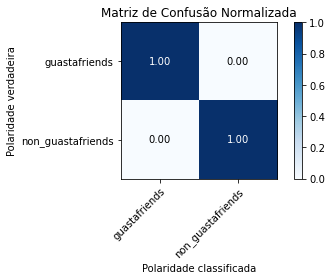

In [27]:
def load_data_split(splitPath):
    # initialize the data and labels
    data = []
    labels = []

    # loop over the rows in the data split file
    for row in open(splitPath):
        # extract the class label and features from the row
        row = row.strip().split(",")
        label = row[0]
        features = np.array(row[1:], dtype="float")

        # update the data and label lists
        data.append(features)
        labels.append(label)

    # convert the data and labels to NumPy arrays
    data = np.array(data)
    labels = np.array(labels)

    # return a tuple of the data and labels
    return (data, labels)
# ======================================================

# derive the paths to the training and testing CSV files
trainingPath = os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, "Train.csv")
testingPath = os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, "Test.csv")

# load the data from disk
log_print("[INFO] loading data...")
(trainX, trainY) = load_data_split(trainingPath)
(testX, testY) = load_data_split(testingPath)

# load the label encoder from disk
le = pickle.loads(open(os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, "le.cpickle"), "rb").read())

# train the model
log_print("[INFO] training model...")
model = LogisticRegression(solver="lbfgs", multi_class="auto")
model.fit(trainX, trainY)

# evaluate the model
log_print("[INFO] evaluating...")
preds = model.predict(testX)
log_print(metrics.classification_report(testY, preds, target_names=le.classes_))
plot_confusion_matrix(testY, preds, np.array(le.classes_), normalize=True)

# serialize the model to disk
log_print("[INFO] saving model...")
plt.savefig(os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, "test_normalized.svg"))
f = open(os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, "model.cpickle"), "wb")
f.write(pickle.dumps(model))
f.close()

## Clean

In [31]:
# load the VGG16 network and initialize the label encoder
log_print("[INFO] loading network...")
vgg16 = VGG16(weights="imagenet", include_top=False)

with open(os.path.join(PATH_CNN_CLEAN_OUTPUT_TYPE, "model.cpickle"), 'rb') as file:
    model = pickle.load(file)

list_accounts = get_accounts()

for acc in list_accounts:
    acc = str(acc).strip()

    log_print("Processing account: " + acc)

    with open(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "user_posts_overview.json"), encoding="utf-8") as json_file:
        posts_overview = json.load(json_file)

    posts_overview_clean = {}
    posts_overview_clean["collected_at"] = posts_overview["collected_at"]
    posts_overview_clean["num_results"] = 0
    posts_overview_clean["items"] = []
    posts_overview_clean["media_count_total"] = 0

    count_image = 1
    log_print("Images:")
    for item in posts_overview["items"]:
        if not "comments_disabled" in item or not item["comments_disabled"]:
            item_copy = item.copy()
            item_copy["media_count"] = 0
            item_copy["images"] = []

            for image in item["images"]:
                imagePath = os.path.join(PATH_FIRST_DATASET_TYPE, acc, "images", str(image['pk']) + ".jpg")
                log_print(str(count_image) + "/" + str(posts_overview["media_count_total"]) + " - " + imagePath)
                count_image += 1

                try_count = 0
                try_again = True
                while try_again:
                    try:
                        batchImages = []
                        image_model = load_img(imagePath, target_size=(224, 224))
                        image_model = img_to_array(image_model)

                        # preprocess the image by (1) expanding the dimensions and
                        # (2) subtracting the mean RGB pixel intensity from the
                        # ImageNet dataset
                        image_model = np.expand_dims(image_model, axis=0)
                        image_model = imagenet_utils.preprocess_input(image_model)

                        batchImages.append(image_model)

                        batchImages = np.vstack(batchImages)
                        features = vgg16.predict(batchImages, batch_size=BATCH_SIZE)
                        features = features.reshape((features.shape[0], 7 * 7 * 512))

                        resul = model.predict(features)

                        if resul[0] == '0':
                            log_print(TYPE + "\n")
                            item_copy["images"].append(image)
                            item_copy["media_count"] += 1
                            posts_overview_clean["media_count_total"] += 1
                        else:
                            log_print("non_" + TYPE + "\n")
                        try_again = False
                    except Exception as err:
                        log_print("Error: " + str(err))
                        log_print("Downloading image again: " + image['url'])
                        resp = requests.get(image['url'], stream=True,timeout=20)  # Open the url image, set stream to True, this will return the stream content.
                        local_file = open(imagePath, 'wb')  # Open a local file with wb ( write binary ) permission.
                        resp.raw.decode_content = True  # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
                        shutil.copyfileobj(resp.raw, local_file)  # Copy the response stream raw data to local image file.
                        try_count += 1
                        if try_count > 3:
                            os.remove(imagePath)
                            error_file = open(os.path.join(folder_path, "deleted_images_path.txt"), 'a')
                            error_file.write(imagePath)
                            error_file.write("\n")
                            error_file.close()
                            try_again = False

            if item_copy["media_count"] > 0:
                posts_overview_clean["items"].append(item_copy)
                posts_overview_clean["num_results"] += 1

    if posts_overview_clean["num_results"] > 0:
        if not os.path.exists(os.path.join(PATH_CLEAN_DATASET_TYPE, acc)):
            os.makedirs(os.path.join(PATH_CLEAN_DATASET_TYPE, acc))
        with open(os.path.join(PATH_CLEAN_DATASET_TYPE, acc, "user_posts_overview_clean.json"), 'w+', encoding="utf-8") as json_file:
            json.dump(posts_overview_clean, json_file, indent=4, ensure_ascii=False)

    print("**********************************************\n")
            
log_print("Finished")

2021-06-21 23:46:09 - [INFO] loading network...
2021-06-21 23:46:09 - Processing account: _guasta
2021-06-21 23:46:09 - Images:
2021-06-21 23:46:09 - 1/12 - D:\IC\tcc_insta\data\1-Creating_Dataset\Dataset\guastafriends\_guasta\images\2508462570224420294.jpg
2021-06-21 23:46:09 - guastafriends

2021-06-21 23:46:09 - 2/12 - D:\IC\tcc_insta\data\1-Creating_Dataset\Dataset\guastafriends\_guasta\images\2488662707093662192.jpg
2021-06-21 23:46:09 - guastafriends

2021-06-21 23:46:09 - 3/12 - D:\IC\tcc_insta\data\1-Creating_Dataset\Dataset\guastafriends\_guasta\images\2477129333418118159.jpg
2021-06-21 23:46:10 - guastafriends

2021-06-21 23:46:10 - 4/12 - D:\IC\tcc_insta\data\1-Creating_Dataset\Dataset\guastafriends\_guasta\images\2433755727346864957.jpg
2021-06-21 23:46:10 - guastafriends

2021-06-21 23:46:10 - 5/12 - D:\IC\tcc_insta\data\1-Creating_Dataset\Dataset\guastafriends\_guasta\images\2432526478128585424.jpg
2021-06-21 23:46:10 - guastafriends

2021-06-21 23:46:10 - 6/12 - D:\IC\tc

2021-06-21 23:46:19 - non_guastafriends

2021-06-21 23:46:19 - 10/24 - D:\IC\tcc_insta\data\1-Creating_Dataset\Dataset\guastafriends\analiviafr\images\2452765368051516486.jpg
2021-06-21 23:46:19 - guastafriends

2021-06-21 23:46:19 - 11/24 - D:\IC\tcc_insta\data\1-Creating_Dataset\Dataset\guastafriends\analiviafr\images\2432513885829744549.jpg
2021-06-21 23:46:20 - non_guastafriends

2021-06-21 23:46:20 - 12/24 - D:\IC\tcc_insta\data\1-Creating_Dataset\Dataset\guastafriends\analiviafr\images\2427798885320090139.jpg
2021-06-21 23:46:20 - guastafriends

2021-06-21 23:46:20 - 13/24 - D:\IC\tcc_insta\data\1-Creating_Dataset\Dataset\guastafriends\analiviafr\images\2421405985413667308.jpg
2021-06-21 23:46:20 - non_guastafriends

2021-06-21 23:46:20 - 14/24 - D:\IC\tcc_insta\data\1-Creating_Dataset\Dataset\guastafriends\analiviafr\images\2399507323372725521.jpg
2021-06-21 23:46:20 - non_guastafriends

2021-06-21 23:46:20 - 15/24 - D:\IC\tcc_insta\data\1-Creating_Dataset\Dataset\guastafriends\

2021-06-21 23:46:33 - 3/3 - D:\IC\tcc_insta\data\1-Creating_Dataset\Dataset\guastafriends\matheuserrera\images\2437443258114555277.jpg
2021-06-21 23:46:33 - guastafriends

2021-06-21 23:46:33 - **********************
2021-06-21 23:46:33 - 




## Moving Images

In [44]:
list_accounts = get_accounts()

for acc in list_accounts:
    acc = str(acc).strip()
    
    log_print(f"Processing account {acc}")
    
    shutil.copyfile(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "user_info.json"), os.path.join(PATH_CLEAN_DATASET_TYPE, acc, "user_info.json"))

    if not os.path.exists(os.path.join(PATH_CLEAN_DATASET_TYPE, acc, "images")):
        os.makedirs(os.path.join(PATH_CLEAN_DATASET_TYPE, acc, "images"))

    with open(os.path.join(PATH_CLEAN_DATASET_TYPE, acc, "user_posts_overview_clean.json"), encoding="utf-8") as json_file:
        overview_clean = json.load(json_file)

    images_moved = len(list(next(os.walk(os.path.join(PATH_CLEAN_DATASET_TYPE, acc, "images")))[2])) - 1 #0 - root, 1 - dirs, 2 - files
    for item in overview_clean["items"]:
        for image in item["images"]:
            if not os.path.exists(os.path.join(PATH_CLEAN_DATASET_TYPE, acc, "images", str(image["pk"]) + ".jpg")):
                log_print(f"{images_moved}/{overview_clean['media_count_total']}")
                images_moved += 1
                shutil.move(os.path.join(PATH_FIRST_DATASET_TYPE, acc, "images", str(image["pk"]) + ".jpg"), os.path.join(PATH_CLEAN_DATASET_TYPE, acc, "images", str(image["pk"]) + ".jpg"))
    print("**********************************************\n")
            
log_print("Finished")

2021-06-22 00:01:04 - Processing account _guasta
**********************************************

2021-06-22 00:01:04 - Processing account joao.squinelato
**********************************************

2021-06-22 00:01:04 - Processing account analiviafr
**********************************************

2021-06-22 00:01:04 - Processing account thayfcruz
**********************************************

2021-06-22 00:01:04 - Processing account mariavuzum
**********************************************

2021-06-22 00:01:04 - Processing account matheuserrera
**********************************************

2021-06-22 00:01:04 - Finished
